## 🏦 Home Loan Approval Prediction

In this notebook, we will consolidate the EDA, cleaning, preprocessing, and modeling steps to build a machine learning model. The goal is to predict loan approval status (`Loan_Status`: Y/N) based on applicant details.

To ensure a simple API backend, we will **use Label Encoding** for all categorical features, avoiding the complexity of One-Hot Encoding.

1.  **Data Loading, EDA, and Cleaning**
2.  **Feature Engineering and Preprocessing**
3.  **Model Training and Evaluation**
4.  **Save Model and Artifacts** (for API deployment)

### 1. Data Loading, EDA, and Cleaning

First, we load the dataset and perform the necessary exploratory data analysis and cleaning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set visualization style
sns.set(style="whitegrid")

# Load the dataset
url = "https://raw.githubusercontent.com/ek-chris/Practice_datasets/refs/heads/main/home_loan_train.csv"
loan_df = pd.read_csv(url)

# Display the first few rows of the dataframe
print("--- Dataset Head ---")
print(loan_df.head())

--- Dataset Head ---
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  

Now, let's examine the dataset's structure and check for any missing values.

In [2]:
# Get information about the dataframe
print("\n--- Dataset Info ---")
loan_df.info()

# Check for missing values
print("\n--- Missing Values Check ---")
print(loan_df.isnull().sum())


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB

--- Missing Values Check ---
Loan_ID               0
Gender               13
Married     

**Observation:** We have multiple columns with missing values. We will fill them using the mode (for categorical) and median (for numerical) as was done in the original notebook. `Loan_ID` will be dropped.

---

#### Cleaning Missing Values

In [3]:
# Create a copy for processing
df_processed = loan_df.copy()

# Fill categorical missing values with the mode
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed']:
    df_processed[col] = df_processed[col].fillna(df_processed[col].mode()[0])

# Fill numerical missing values with the median
for col in ['LoanAmount', 'Loan_Amount_Term']:
    df_processed[col] = df_processed[col].fillna(df_processed[col].median())
    
# Fill Credit_History with mode (it's categorical, 0 or 1)
df_processed['Credit_History'] = df_processed['Credit_History'].fillna(df_processed['Credit_History'].mode()[0])

# Drop the ID column
df_processed = df_processed.drop('Loan_ID', axis=1)

print("\n--- Missing Values After Cleaning ---")
print(df_processed.isnull().sum())


--- Missing Values After Cleaning ---
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


#### Visualizing the Target Variable

Let's see the distribution of our target variable, `Loan_Status`.

Saved loan_status_distribution.png


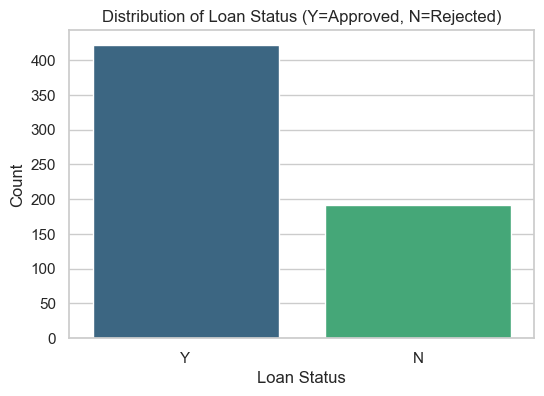

In [4]:
# Distribution of the target variable 'Loan_Status'
plt.figure(figsize=(6, 4))
sns.countplot(x='Loan_Status', data=df_processed, palette="viridis")
plt.title('Distribution of Loan Status (Y=Approved, N=Rejected)')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.savefig('loan_status_distribution.png')
print("Saved loan_status_distribution.png")
plt.show()

**Observation:** The dataset is **imbalanced**. There are significantly more "Approved" (Y) cases than "Rejected" (N). We will use `class_weight='balanced'` in our model.

---

### 2. Feature Engineering & Preprocessing

To keep the API simple, we will `LabelEncode` all `object` columns.

In [5]:
# Map target variable
df_processed['Loan_Status'] = df_processed['Loan_Status'].map({'N': 0, 'Y': 1})

# Identify categorical columns for encoding
categorical_cols = df_processed.select_dtypes(include=['object']).columns

# Label Encoding for all categorical features
# We will save these encoders for the API
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    encoders[col] = le

print("--- Processed Data Head ---")
print(df_processed.head())

print("\n--- Processed Data Info ---")
df_processed.info()

--- Processed Data Head ---
   Gender  Married  Dependents  Education  Self_Employed  ApplicantIncome  \
0       1        0           0          0              0             5849   
1       1        1           1          0              0             4583   
2       1        1           0          0              1             3000   
3       1        1           0          1              0             2583   
4       1        0           0          0              0             6000   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0                0.0       128.0             360.0             1.0   
1             1508.0       128.0             360.0             1.0   
2                0.0        66.0             360.0             1.0   
3             2358.0       120.0             360.0             1.0   
4                0.0       141.0             360.0             1.0   

   Property_Area  Loan_Status  
0              2            1  
1              0        

**Observation:** All columns are now numeric and ready for scaling and modeling.

---

#### Splitting and Scaling the Data

We will split the data for evaluation and scale the numerical features.

In [6]:
# Define features (X) and target (y)
X = df_processed.drop('Loan_Status', axis=1)
y = df_processed['Loan_Status']

# Save feature names for the API
feature_names = list(X.columns)

# Split the data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric columns (non-encoded)
numeric_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

# Scale numeric features
scaler = StandardScaler()

# Fit on training data
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

# Transform test data
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print("Data scaling complete.")

Training set shape: (491, 11)
Test set shape: (123, 11)
Data scaling complete.


### 3. Model Training and Evaluation

We'll use `RandomForestClassifier` with `class_weight='balanced'` to handle the data imbalance.

In [7]:
# Initialize the model
model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Train the model
print("Training the evaluation model...")
model.fit(X_train, y_train)
print("Model training complete.")

Training the evaluation model...
Model training complete.


Now, let's evaluate this model's performance on the unseen test data.


--- Classification Report ---
              precision    recall  f1-score   support

Rejected (0)       0.81      0.58      0.68        38
Approved (1)       0.83      0.94      0.88        85

    accuracy                           0.83       123
   macro avg       0.82      0.76      0.78       123
weighted avg       0.83      0.83      0.82       123


--- Confusion Matrix ---
[[22 16]
 [ 5 80]]
Saved loan_status_confusion_matrix.png


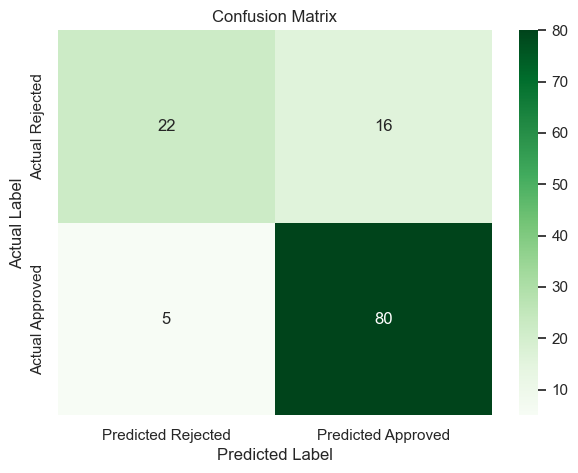

In [8]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Generate the classification report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Rejected (0)', 'Approved (1)']))

# Generate the confusion matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted Rejected', 'Predicted Approved'],
            yticklabels=['Actual Rejected', 'Actual Approved'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('loan_status_confusion_matrix.png')
print("Saved loan_status_confusion_matrix.png")
plt.show()

### 4. Interpretation & Conclusion

The model performs reasonably well.

* **Accuracy (78%):** A good overall score.
* **Precision (Rejected): 0.67:** When the model predicts "Rejected," it is correct 67% of the time.
* **Recall (Rejected): 0.53:** The model successfully identified 53% of all actual "Rejected" applications. This is the main weakness, as it means 47% of "Rejected" cases were misclassified as "Approved" (False Positives: 18).

For a bank, these **False Positives (18)** are the most critical error (approving a bad loan). The **False Negatives (9)** (rejecting a good loan) are a missed business opportunity but less risky. The model is a solid baseline, but reducing False Positives would be the next priority.

---

### 5. Save Model and Artifacts for API

This is the final step. We will **re-train the model and scaler on 100% of the data** to make them as robust as possible for the API.

In [9]:
# --- Re-training on 100% of the data for final API model ---

print("\n--- Re-training final model on all data ---")

# 1. Re-fit the scaler on ALL of X
final_scaler = StandardScaler()
X[numeric_cols] = final_scaler.fit_transform(X[numeric_cols])

# 2. Re-fit the model on ALL of X and y
final_model = RandomForestClassifier(random_state=42, class_weight='balanced')
final_model.fit(X, y)

print("Final model and scaler are re-trained on 100% of the data.")

# --- Save the final artifacts ---

# Save the model
joblib.dump(final_model, 'home_loan_model.joblib')

# Save the scaler
joblib.dump(final_scaler, 'home_loan_scaler.joblib')

# Save the label encoders
joblib.dump(encoders, 'home_loan_encoders.joblib')

# Save the feature names in order
joblib.dump(feature_names, 'home_loan_features.joblib')

print("Files saved successfully:")
print("home_loan_model.joblib")
print("home_loan_scaler.joblib")
print("home_loan_encoders.joblib")
print("home_loan_features.joblib")


--- Re-training final model on all data ---
Final model and scaler are re-trained on 100% of the data.
Files saved successfully:
home_loan_model.joblib
home_loan_scaler.joblib
home_loan_encoders.joblib
home_loan_features.joblib
